##Revised Amazon Alexa Challenge
The goal of this challenge is to clean, explore, and visualize this data to create a sentiment analysis model to predict the rating based on the review text. Let's get started.

In [1]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
nltk.download('stopwords')
nltk.download('punkt')
from sklearn.model_selection import train_test_split
from sklearn import metrics
!pip install catboost
from catboost import CatBoostClassifier,Pool

# Fetch dataset
AlexaReviews = pd.read_csv('https://s3-us-west-2.amazonaws.com/patchworks-coding-challenge/amazon_alexa.tsv', sep='\t')

# View datatypes within each dataset, the shape and the first 10 rows
AlexaReviews.shape
print(' ')
print('Alexa Reviews Dataset')
print(AlexaReviews.dtypes)
print(' ')

print(AlexaReviews.shape)
print(' ')
AlexaReviews.head(10)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
 
Alexa Reviews Dataset
rating               int64
date                object
variation           object
verified_reviews    object
feedback             int64
dtype: object
 
(3150, 5)
 


,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1
5,5,31-Jul-18,Heather Gray Fabric,I received the echo as a gift. I needed anothe...,1
6,3,31-Jul-18,Sandstone Fabric,"Without having a cellphone, I cannot use many ...",1
7,5,31-Jul-18,Charcoal Fabric,I think this is the 5th one I've purchased. I'...,1
8,5,30-Jul-18,Heather Gray Fabric,looks great,1
9,5,30-Jul-18,Heather Gray Fabric,Love it! I’ve listened to songs I haven’t hear...,1


###Challenge 1:

It's been discovered that all verified_reviews that are only say "love it" or are only one word are actually fake. Reviews like "great!" or "Love It!" need to be removed from the dataset.

We therefore remove them as follows:

In [2]:
# Count the number of spaces in each review and store the resulting list in a Pandas series
counter = AlexaReviews['verified_reviews'].str.count(' ')

# Join it to the AlexaReviews dataframe like so:
AlexaReviews.loc[:, 'space_counter'] = counter

# Filter out 1-word reviews i.e. space counter of 0:
authentic = AlexaReviews['space_counter'] > 0
AlexaReviews = AlexaReviews[authentic]

# Finally, we can drop the space_counter column because we don't need it anymore
AlexaReviews = AlexaReviews.drop(['space_counter'], axis = 1)

print(AlexaReviews.shape)
print(' ')
AlexaReviews.head(5)

(3077, 5)
 


,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
5,5,31-Jul-18,Heather Gray Fabric,I received the echo as a gift. I needed anothe...,1


In [3]:
# Make the reviews lowercase
AlexaReviews['verified_reviews'] = AlexaReviews['verified_reviews'].str.lower()

# Remove all punctuation
AlexaReviews['verified_reviews'] = AlexaReviews['verified_reviews'].str.replace('[^\w\s]', '')

# Remove all strings that are either "love it!" or "love it"
AlexaReviews = AlexaReviews[AlexaReviews['verified_reviews'] != ' ']
AlexaReviews = AlexaReviews[AlexaReviews['verified_reviews'] != 'love it']
AlexaReviews = AlexaReviews[AlexaReviews['verified_reviews'] != 'loved it']

print(AlexaReviews.shape)
AlexaReviews.head(5)

(2943, 5)


,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,love my echo,1
2,4,31-Jul-18,Walnut Finish,sometimes while playing a game you can answer ...,1
3,5,31-Jul-18,Charcoal Fabric,i have had a lot of fun with this thing my 4 y...,1
5,5,31-Jul-18,Heather Gray Fabric,i received the echo as a gift i needed another...,1
6,3,31-Jul-18,Sandstone Fabric,without having a cellphone i cannot use many o...,1


###Challenge 2:

To visualize the data:

1.   Create a bar graph showing the number of reviews per day from the date of the first review to the date of the last review
2.   Create a histogram of ratings

All graphs must have labels for X and Y axes.

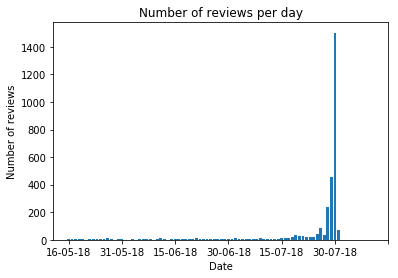

In [4]:
# Change the format of the date column to date-time
AlexaReviews['date'] = pd.to_datetime(AlexaReviews['date'])

# Group the data by the date column
grouped_df = AlexaReviews.groupby(['date'])

# then create a new dataframe of these grouped values
GroupCount = pd.DataFrame(grouped_df.size().reset_index(name = 'group_count'))

# Change back the format of the date column to string
GroupCount['date'] = GroupCount['date'].dt.strftime('%d-%m-%y')

# Create a graph of our values:
plt.bar(GroupCount['date'], GroupCount['group_count'])
plt.xlabel('Date')
plt.xticks(np.arange(0, 100, step = 15))
plt.ylabel('Number of reviews')
plt.title('Number of reviews per day')

plt.show()

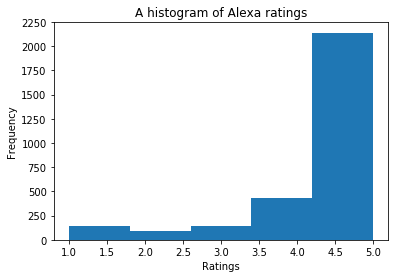

In [5]:
# Create a histogram of ratings
plt.hist(AlexaReviews['rating'], bins = 5)
plt.xlabel('Ratings')
plt.ylabel('Frequency')
plt.title('A histogram of Alexa ratings')
plt.show()

###Challenge 3:

Let's create some features for our model.

1.   Create a new column called "verified_reviews_clean" that removes filler words from "verified_reviews" like "the", "a", "and", "I", etc.
2.   Find the most common non-filler words for each rating score.
1.   Create dummy variables (1 or 0) for the presence of these words in each review.



In [6]:
# Remove filler words:
stop = set(nltk.corpus.stopwords.words('english'))
AlexaReviews['vr_clean'] = AlexaReviews['verified_reviews'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

print(AlexaReviews.shape)
print(' ')
AlexaReviews.head(10)

(2943, 6)
 


,rating,date,variation,verified_reviews,feedback,vr_clean
0,5,2018-07-31,Charcoal Fabric,love my echo,1,love echo
2,4,2018-07-31,Walnut Finish,sometimes while playing a game you can answer ...,1,sometimes playing game answer question correct...
3,5,2018-07-31,Charcoal Fabric,i have had a lot of fun with this thing my 4 y...,1,lot fun thing 4 yr old learns dinosaurs contro...
5,5,2018-07-31,Heather Gray Fabric,i received the echo as a gift i needed another...,1,received echo gift needed another bluetooth so...
6,3,2018-07-31,Sandstone Fabric,without having a cellphone i cannot use many o...,1,without cellphone cannot use many features ipa...
7,5,2018-07-31,Charcoal Fabric,i think this is the 5th one ive purchased im w...,1,think 5th one ive purchased im working getting...
8,5,2018-07-30,Heather Gray Fabric,looks great,1,looks great
9,5,2018-07-30,Heather Gray Fabric,love it ive listened to songs i havent heard s...,1,love ive listened songs havent heard since chi...
10,5,2018-07-30,Charcoal Fabric,i sent it to my 85 year old dad and he talks t...,1,sent 85 year old dad talks constantly
11,5,2018-07-30,Charcoal Fabric,i love it learning knew things with it eveyday...,1,love learning knew things eveyday still figuri...


In [7]:
# Tokenize words
tokenized_vr_clean = [word_tokenize(i) for i in AlexaReviews['vr_clean']]
AlexaReviews.loc[:, 'tokenized_vr_clean'] = tokenized_vr_clean

# Split the dataset into 5, grouping reviews with the same rating together
one_star_ratings = AlexaReviews[AlexaReviews['rating'] == 1]
two_star_ratings = AlexaReviews[AlexaReviews['rating'] == 2]
three_star_ratings = AlexaReviews[AlexaReviews['rating'] == 3]
four_star_ratings = AlexaReviews[AlexaReviews['rating'] == 4]
five_star_ratings = AlexaReviews[AlexaReviews['rating'] == 5]

# Pick the most common expression in all 5 datasets
datasets = [one_star_ratings,
            two_star_ratings,
            three_star_ratings,
            four_star_ratings,
            five_star_ratings]

i = 1

for dataset in datasets:
  allWords = []
  for wordList in dataset['tokenized_vr_clean']:
    allWords += wordList
    
  dataset_Fdist = nltk.FreqDist(allWords)
  dataset_mode = dataset_Fdist.most_common(10)
  
  print('most common words in a typical \n{}-star review'.format(i))
  print(dataset_mode)
  print(" ")
  i += 1

most common words in a typical 
1-star review
[('echo', 49), ('amazon', 43), ('would', 31), ('one', 28), ('dot', 26), ('device', 25), ('work', 24), ('product', 24), ('get', 22), ('bought', 19)]
 
most common words in a typical 
2-star review
[('echo', 41), ('alexa', 35), ('device', 29), ('like', 27), ('music', 24), ('would', 22), ('play', 22), ('sound', 21), ('get', 20), ('use', 20)]
 
most common words in a typical 
3-star review
[('echo', 53), ('alexa', 51), ('like', 36), ('speaker', 30), ('music', 28), ('sound', 27), ('doesnt', 26), ('quality', 26), ('dot', 26), ('better', 24)]
 
most common words in a typical 
4-star review
[('echo', 150), ('great', 123), ('like', 117), ('alexa', 112), ('music', 100), ('use', 97), ('love', 86), ('good', 69), ('sound', 68), ('would', 68)]
 
most common words in a typical 
5-star review
[('love', 796), ('great', 549), ('echo', 533), ('alexa', 378), ('music', 364), ('use', 317), ('like', 304), ('easy', 289), ('works', 277), ('one', 238)]
 


Based on the output above, we need to remove words shared across the different ratings and brand/product mentions:

In [8]:
# Remove generic words for one_star_ratings:
stop = set(['echo', 'amazon', 'would', 'device', 'product', 'get', 'dot', 'one', 'alexa'])
one_star_ratings.loc[:, 'vr_clean_twice'] = one_star_ratings['vr_clean'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

# Remove generic words for two_star_ratings:
stop = set(['echo', 'alexa', 'device', 'music', 'would', 'get', 'sound', 'use', 'amazon'])
two_star_ratings.loc[:, 'vr_clean_twice'] = two_star_ratings['vr_clean'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

# Remove generic words for three_star_ratings:
stop = set(['echo', 'alexa', 'speaker', 'music', 'sound', 'dot'])
three_star_ratings.loc[:, 'vr_clean_twice'] = three_star_ratings['vr_clean'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

# Remove generic words for four_star_ratings:
stop = set(['echo', 'alexa', 'music', 'use', 'sound', 'would', 'speaker'])
four_star_ratings.loc[:, 'vr_clean_twice'] = four_star_ratings['vr_clean'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

# Remove generic words for five_star_ratings:
stop = set(['echo', 'alexa', 'music', 'use', 'one'])
five_star_ratings.loc[:,'vr_clean_twice'] = five_star_ratings['vr_clean'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [9]:
# Pick the most common expression in all 5 datasets
datasets = [one_star_ratings,
            two_star_ratings,
            three_star_ratings,
            four_star_ratings,
            five_star_ratings]

i = 1

for dataset in datasets:
  tokenized_vr_clean_twice = [word_tokenize(i) for i in dataset['vr_clean_twice']]
  dataset.loc[:, 'tokenized_vr_clean_twice'] = tokenized_vr_clean_twice

  allWords = []
  for wordList in dataset['tokenized_vr_clean_twice']:
    allWords += wordList
    
  dataset_Fdist = nltk.FreqDist(allWords)
  dataset_mode = dataset_Fdist.most_common(5)
  
  print('5 most common words in a typical \n{}-star review'.format(i))
  print(dataset_mode)
  print(" ")
  i += 1

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


5 most common words in a typical 
1-star review
[('work', 24), ('bought', 19), ('time', 19), ('works', 18), ('doesnt', 18)]
 
5 most common words in a typical 
2-star review
[('like', 27), ('play', 22), ('work', 19), ('dont', 17), ('time', 16)]
 
5 most common words in a typical 
3-star review
[('like', 36), ('doesnt', 26), ('quality', 26), ('better', 24), ('well', 24)]
 
5 most common words in a typical 
4-star review
[('great', 123), ('like', 117), ('love', 86), ('good', 69), ('works', 62)]
 
5 most common words in a typical 
5-star review
[('love', 796), ('great', 549), ('like', 304), ('easy', 289), ('works', 277)]
 


With the top 5 words found for each type of review, they can be dummified and added to the original dataset.

In [10]:
# Based on the above analysis the features to be dummified are:
# 1. Love          6. Good           11. Play
# 2. Great         7. Doesnt         12. Work
# 3. Like          8. Quality        13. Dont
# 4. Easy          9. Better         14. Time
# 5. Works        10. Well           15. Bought

AlexaReviews.loc[:, 'love_dummy'] = AlexaReviews['vr_clean'].str.contains('love', regex=True).astype(int)
AlexaReviews.loc[:, 'great_dummy'] = AlexaReviews['vr_clean'].str.contains('great', regex=True).astype(int)
AlexaReviews.loc[:, 'like_dummy'] = AlexaReviews['vr_clean'].str.contains('like', regex=True).astype(int)
AlexaReviews.loc[:, 'easy_dummy'] = AlexaReviews['vr_clean'].str.contains('easy', regex=True).astype(int)
AlexaReviews.loc[:, 'works_dummy'] = AlexaReviews['vr_clean'].str.contains('works', regex=True).astype(int)
AlexaReviews.loc[:, 'good_dummy'] = AlexaReviews['vr_clean'].str.contains('good', regex=True).astype(int)
AlexaReviews.loc[:, 'doesnt_dummy'] = AlexaReviews['vr_clean'].str.contains('doesnt', regex=True).astype(int)
AlexaReviews.loc[:, 'quality_dummy'] = AlexaReviews['vr_clean'].str.contains('quality', regex=True).astype(int)
AlexaReviews.loc[:, 'better_dummy'] = AlexaReviews['vr_clean'].str.contains('better', regex=True).astype(int)
AlexaReviews.loc[:, 'well_dummy'] = AlexaReviews['vr_clean'].str.contains('well', regex=True).astype(int)
AlexaReviews.loc[:, 'play_dummy'] = AlexaReviews['vr_clean'].str.contains('play', regex=True).astype(int)
AlexaReviews.loc[:, 'work_dummy'] = AlexaReviews['vr_clean'].str.contains('work', regex=True).astype(int)
AlexaReviews.loc[:, 'dont_dummy'] = AlexaReviews['vr_clean'].str.contains('dont', regex=True).astype(int)
AlexaReviews.loc[:, 'time_dummy'] = AlexaReviews['vr_clean'].str.contains('time', regex=True).astype(int)
AlexaReviews.loc[:, 'bought_dummy'] = AlexaReviews['vr_clean'].str.contains('bought', regex=True).astype(int)

#Finally, delete unnecessary columns
AlexaReviews = AlexaReviews.drop(labels = 'tokenized_vr_clean', axis = 1)
AlexaReviews = AlexaReviews.drop(labels = 'vr_clean', axis = 1)
AlexaReviews = AlexaReviews.drop(labels = 'feedback', axis = 1)
AlexaReviews = AlexaReviews.drop(labels = 'verified_reviews', axis = 1)
AlexaReviews = AlexaReviews.drop(labels = 'variation', axis = 1)
AlexaReviews = AlexaReviews.drop(labels = 'date', axis = 1)

AlexaReviews.head(5)

,rating,love_dummy,great_dummy,like_dummy,easy_dummy,works_dummy,good_dummy,doesnt_dummy,quality_dummy,better_dummy,well_dummy,play_dummy,work_dummy,dont_dummy,time_dummy,bought_dummy
0,5,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,4,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0
3,5,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0
5,5,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
6,3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


###Challenge 4:
Create a model using your new features to predict the rating score given the review.
1.   Split the dataset into a training and test set using the method of your choice.
2.   Create a column called "predicted_rating" and use the model of your choice to achieve the best accuracy possible. Explain how you chose your model and loss function.

In [0]:
# At this point, we need to separate the label (rating) from the features
Label = AlexaReviews['rating']
Features = AlexaReviews
Features = Features.drop(labels = 'rating', axis = 1)

In [0]:
# Split the dataset and prepare for modelling
x_features, y_features, x_label, y_label = train_test_split(Features, Label, test_size=0.3)

train_pool = Pool(x_features, 
                  x_label, 
                  cat_features=['love_dummy',
                                'great_dummy',
                                'like_dummy',
                                'easy_dummy',
                                'works_dummy',
                                'good_dummy',
                                'doesnt_dummy',
                                'quality_dummy',
                                'better_dummy',
                                'well_dummy',
                                'play_dummy',
                                'work_dummy',
                                'dont_dummy',
                                'time_dummy',
                                'bought_dummy'])

validate_pool = Pool(y_features,
                  cat_features=['love_dummy',
                                'great_dummy',
                                'like_dummy',
                                'easy_dummy',
                                'works_dummy',
                                'good_dummy',
                                'doesnt_dummy',
                                'quality_dummy',
                                'better_dummy',
                                'well_dummy',
                                'play_dummy',
                                'work_dummy',
                                'dont_dummy',
                                'time_dummy',
                                'bought_dummy'])

In [15]:
# Model
model = CatBoostClassifier(iterations=200,
                          loss_function='MultiClass',
                          eval_metric='Accuracy')

model.fit(train_pool)

# and predict
answer = model.predict(validate_pool)

0:	learn: 0.7344660	total: 5.4ms	remaining: 1.07s
1:	learn: 0.7339806	total: 10.2ms	remaining: 1.01s
2:	learn: 0.7310680	total: 13.5ms	remaining: 887ms
3:	learn: 0.7310680	total: 16.7ms	remaining: 816ms
4:	learn: 0.7276699	total: 18.5ms	remaining: 723ms
5:	learn: 0.7266990	total: 20.4ms	remaining: 660ms
6:	learn: 0.7266990	total: 24.9ms	remaining: 687ms
7:	learn: 0.7266990	total: 27.3ms	remaining: 655ms
8:	learn: 0.7266990	total: 31.6ms	remaining: 671ms
9:	learn: 0.7266990	total: 36.1ms	remaining: 687ms
10:	learn: 0.7276699	total: 39.2ms	remaining: 674ms
11:	learn: 0.7281553	total: 44.2ms	remaining: 692ms
12:	learn: 0.7281553	total: 46.1ms	remaining: 664ms
13:	learn: 0.7281553	total: 50.6ms	remaining: 672ms
14:	learn: 0.7286408	total: 56.1ms	remaining: 692ms
15:	learn: 0.7291262	total: 60.8ms	remaining: 699ms
16:	learn: 0.7305825	total: 65.3ms	remaining: 703ms
17:	learn: 0.7305825	total: 70.1ms	remaining: 709ms
18:	learn: 0.7310680	total: 74.8ms	remaining: 713ms
19:	learn: 0.7315534	to

The CatBoost classifier was a model that I selected because I needed more than 1 output (I had to have 5 predicted ratings).